# Forecasting International Airline Passengers 

In [47]:
#importing the general packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
# Ignoring the warning
import warnings
warnings.filterwarnings('ignore')

In [96]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping

In [50]:
from time import time
import math
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf

In [51]:
# Reading the text file
df =pd.read_csv('airline-passengers.txt')

# Understanding the data

In [52]:
#Visualizing the data
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [53]:
#Converting the Month column into date time format
#df['datetime']=pd.to_datetime(df.Month)
df['datetime']=pd.to_datetime(df['Month']).dt.to_period('M')
#df['datetime']=pd.to_datetime(df.Month, infer_datetime_format=True)

In [54]:
# Let's Visualize it
df.head(10)

,Month,Passengers,datetime
0,1949-01,112,1949-01
1,1949-02,118,1949-02
2,1949-03,132,1949-03
3,1949-04,129,1949-04
4,1949-05,121,1949-05
5,1949-06,135,1949-06
6,1949-07,148,1949-07
7,1949-08,148,1949-08
8,1949-09,136,1949-09
9,1949-10,119,1949-10


In [55]:
#Create year, quarter, month features
df['year'] = df['datetime'].apply(lambda x: x.year)
df['quarter'] = df['datetime'].apply(lambda x: x.quarter)
df['month'] = df['datetime'].apply(lambda x: x.month)

In [56]:
# Again visualizing
df.head()

,Month,Passengers,datetime,year,quarter,month
0,1949-01,112,1949-01,1949,1,1
1,1949-02,118,1949-02,1949,1,2
2,1949-03,132,1949-03,1949,1,3
3,1949-04,129,1949-04,1949,2,4
4,1949-05,121,1949-05,1949,2,5


In [57]:
#data shape
df.shape

(144, 6)

In [58]:
#Looking null values
df.isnull().sum()

Month         0
Passengers    0
datetime      0
year          0
quarter       0
month         0
dtype: int64

In [59]:
#looking the datatype
df.dtypes

Month            object
Passengers        int64
datetime      period[M]
year              int64
quarter           int64
month             int64
dtype: object

-Statistical testing of data for normality
 -Our null hypothesis H_o= the data is normal

        -p <= 0.05: reject_H0, not normal.
        -p > 0.05: fail to reject H0, normal.

In [60]:
#Calculating the statistic and p-value 
stat, p = stats.normaltest(df.Passengers)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=8.655, p=0.013
Data does not look Gaussian (reject H0)


In [61]:
#Looking at the general statistics of Global_active_power
df.Passengers.describe()

count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: Passengers, dtype: float64

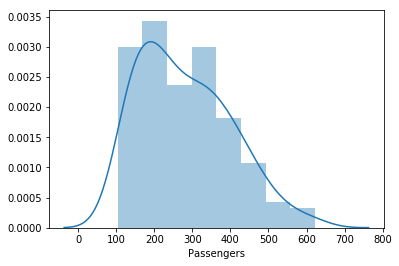

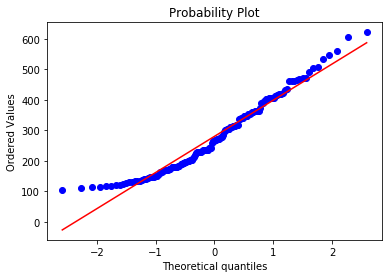

In [62]:
# data distribution by distplot & probability plot for normality test 
plt.figure()
sns.distplot(df.Passengers);
plt.figure()
stats.probplot(df['Passengers'], plot=plt);

In [63]:
# Let's look at the skewness and Kurtosis of the data
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Passengers)))
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Passengers)))

Skewness of normal distribution: 0.577068234901525
Kurtosis of normal distribution: -0.39377217091281036


# Let's Visualize the data

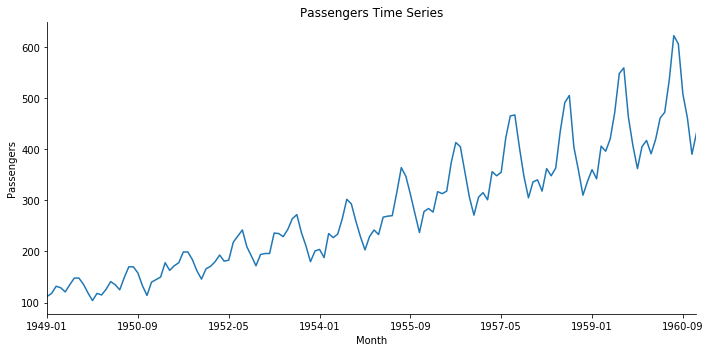

In [64]:
# Ploting the Global_active_power against the time
df1=df.loc[:,['Month','Passengers']]
df1.set_index('Month',inplace=True)
df1.plot(figsize=(10,5))
plt.title('Passengers over Month')
plt.ylabel('Passengers')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Passengers Time Series')
sns.despine(top=True)
plt.show();

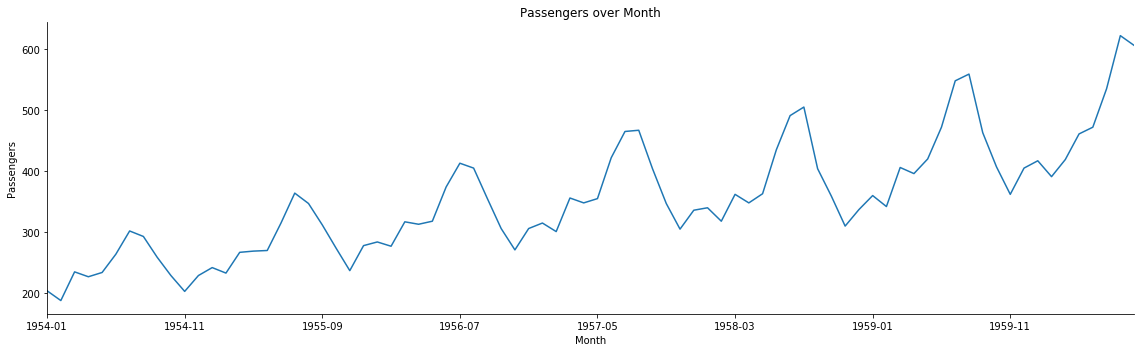

In [65]:
#Passengers over Month for certain time period 
df2=df1[(df1.index>='1954-01') & (df1.index<'1960-09')]
df2.plot(figsize=(16,5));
plt.title('Passengers over Month')
plt.ylabel('Passengers')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show();

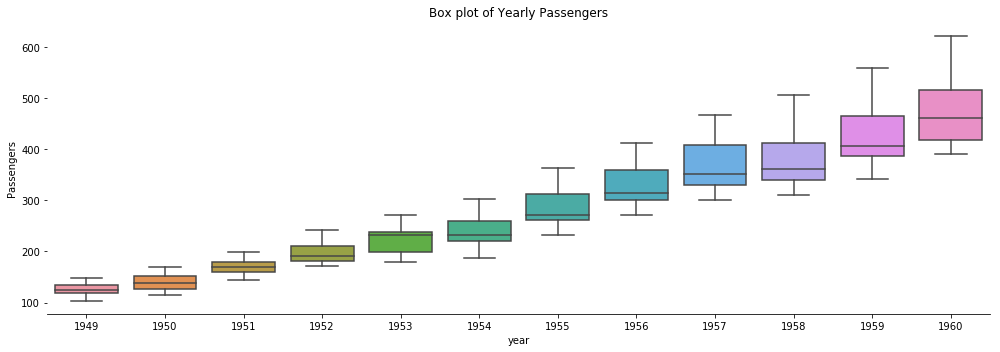

In [66]:
#Box plot for yearly Passengers
plt.figure(figsize=(14,5))
sns.boxplot(x="year", y="Passengers", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Passengers')
sns.despine(left=True)
plt.tight_layout() 

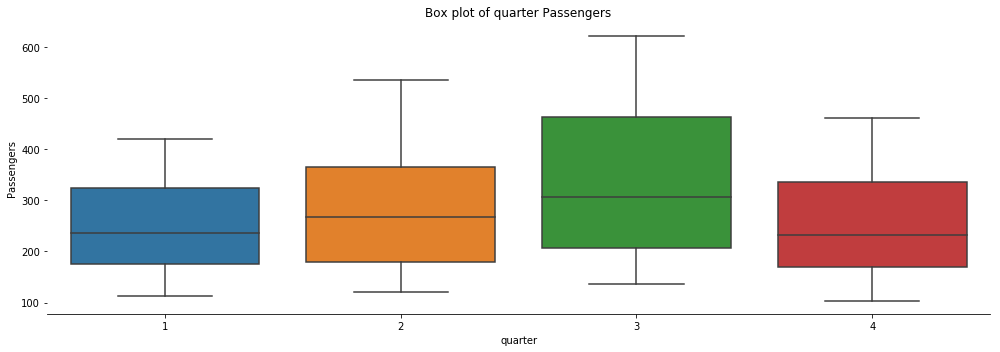

In [67]:
#Box plot for Quartely Passengers
plt.figure(figsize=(14,5))
sns.boxplot(x="quarter", y="Passengers", data=df)
plt.xlabel('quarter')
plt.title('Box plot of quarter Passengers')
sns.despine(left=True)
plt.tight_layout() 

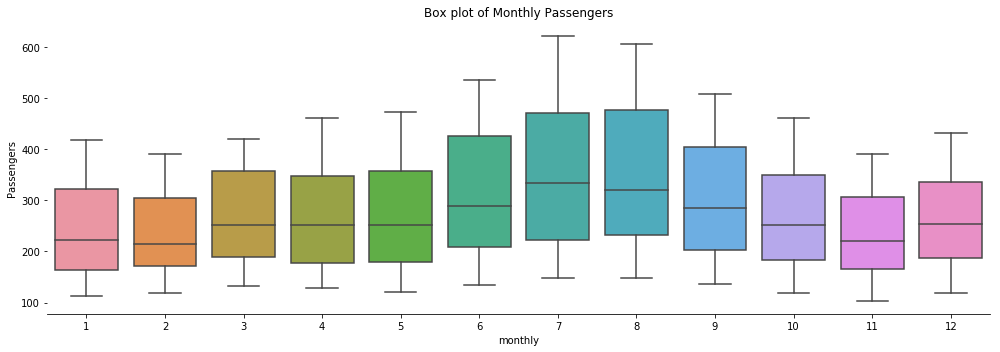

In [68]:
#Box plot for Monthly Passengers
plt.figure(figsize=(14,5))
sns.boxplot(x="month", y="Passengers", data=df)
plt.xlabel('monthly')
plt.title('Box plot of Monthly Passengers')
sns.despine(left=True)
plt.tight_layout()

Text(0.5, 1.0, 'Mean Passengers by Month')

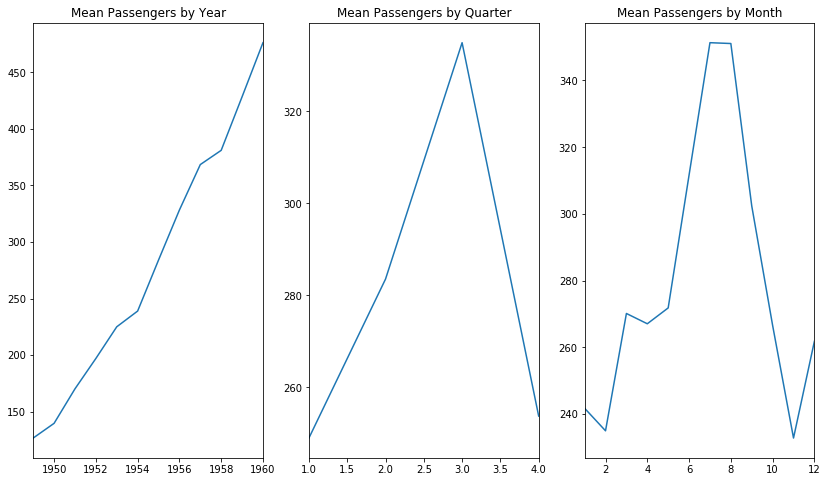

In [69]:
# Let's look at the Average Passengers over different period 
plt.figure(figsize=(14,8))
plt.subplot(1,3,1)
df.groupby('year').Passengers.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Passengers by Year')

plt.subplot(1,3,2)
df.groupby('quarter').Passengers.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Passengers by Quarter')

plt.subplot(1,3,3)
df.groupby('month').Passengers.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Passengers by Month')

In [73]:
# create the dataset for Passengers
data1 = df.Passengers.values 
data1 = data1.astype('float32')

In [74]:
## data scaling or transformation: MinMax scaling
data1 = np.reshape(data1, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
data1 = scaler.fit_transform(data1)

In [75]:
# Train Test split of data: 80-20 ratio
train_size = int(len(data1) * 0.80)
test_size = len(data1) - train_size
train, test = data1[0:train_size,:], data1[train_size:len(data1),:]

In [76]:
# pring train test size
train.shape, test.shape

((115, 1), (29, 1))

# Modeling

Before doing the forescasting we need to convert arry to the matrix 

In [125]:
#Convert an array of values into a dataset matrix
def Matrix_convertion(data1, look_back=1):
    X, Y = [], []
    for i in range(len(data1)-look_back-1):
        a = data1[i:(i+look_back), 0]
        X.append(a)
        Y.append(data1[i + look_back, 0])
    return np.array(X), np.array(Y)

In [149]:
# reshape into X=t and Y=t+1
look_back = 8
X_train, Y_train = Matrix_convertion(train, look_back)
X_test, Y_test = Matrix_convertion(test, look_back)

In [150]:
X_train.shape, Y_train.shape

((106, 8), (106,))

In [151]:
X_test.shape, Y_test.shape

((20, 8), (20,))

In [152]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [153]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)
# Training Phase
model.summary()

Train on 106 samples, validate on 20 samples
Epoch 1/100
106/106 [==============================] - 2s 19ms/step - loss: 0.0864 - val_loss: 0.3976
Epoch 2/100
106/106 [==============================] - 0s 117us/step - loss: 0.0750 - val_loss: 0.3538
Epoch 3/100
106/106 [==============================] - 0s 143us/step - loss: 0.0654 - val_loss: 0.3112
Epoch 4/100
106/106 [==============================] - 0s 136us/step - loss: 0.0550 - val_loss: 0.2719
Epoch 5/100
106/106 [==============================] - 0s 150us/step - loss: 0.0468 - val_loss: 0.2355
Epoch 6/100
106/106 [==============================] - 0s 153us/step - loss: 0.0381 - val_loss: 0.2021
Epoch 7/100
106/106 [==============================] - 0s 146us/step - loss: 0.0310 - val_loss: 0.1719
Epoch 8/100
106/106 [==============================] - 0s 127us/step - loss: 0.0268 - val_loss: 0.1448
Epoch 9/100
106/106 [==============================] - 0s 101us/step - loss: 0.0216 - val_loss: 0.1210
Epoch 10/100
106/106 [=======

In [154]:
# predicting for train and test set
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [155]:
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [156]:
# printing the RMSE (root mean square error) and MAE(mean absolute error)
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 36.038007736452045
Train Root Mean Squared Error: 45.01562047431031
Test Mean Absolute Error: 76.80857528224593
Test Root Mean Squared Error: 98.78377196521241


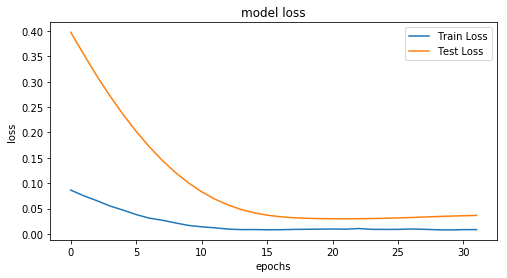

In [157]:
# plotting the loss for training data and test data
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

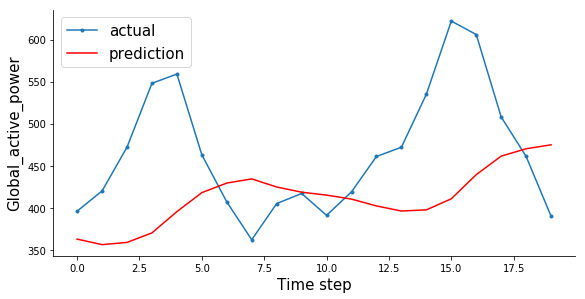

In [158]:
# Plotting the actual vs predicted data
aa=[x for x in range(20)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:20], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:20], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# Using Different Techniques

In [164]:
# normalize the passengers
passenger_value = df.Passengers.values
passenger_value = passenger_value.astype('float32')
passenger_value = np.reshape(passenger_value, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(passenger_value)

In [169]:
print(dataset[:4])

[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]]


In [170]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

100 44


In [173]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [174]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [175]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [176]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 3s - loss: 0.0410
Epoch 2/100
 - 0s - loss: 0.0188
Epoch 3/100
 - 0s - loss: 0.0148
Epoch 4/100
 - 0s - loss: 0.0134
Epoch 5/100
 - 0s - loss: 0.0123
Epoch 6/100
 - 0s - loss: 0.0114
Epoch 7/100
 - 0s - loss: 0.0102
Epoch 8/100
 - 0s - loss: 0.0092
Epoch 9/100
 - 0s - loss: 0.0081
Epoch 10/100
 - 0s - loss: 0.0072
Epoch 11/100
 - 0s - loss: 0.0064
Epoch 12/100
 - 0s - loss: 0.0055
Epoch 13/100
 - 0s - loss: 0.0048
Epoch 14/100
 - 0s - loss: 0.0043
Epoch 15/100
 - 0s - loss: 0.0036
Epoch 16/100
 - 0s - loss: 0.0033
Epoch 17/100
 - 0s - loss: 0.0029
Epoch 18/100
 - 0s - loss: 0.0027
Epoch 19/100
 - 0s - loss: 0.0025
Epoch 20/100
 - 0s - loss: 0.0024
Epoch 21/100
 - 0s - loss: 0.0024
Epoch 22/100
 - 0s - loss: 0.0023
Epoch 23/100
 - 0s - loss: 0.0022
Epoch 24/100
 - 0s - loss: 0.0022
Epoch 25/100
 - 0s - loss: 0.0022
Epoch 26/100
 - 0s - loss: 0.0022
Epoch 27/100
 - 0s - loss: 0.0022
Epoch 28/100
 - 0s - loss: 0.0022
Epoch 29/100
 - 0s - loss: 0.0022
Epoch 30/100
 - 0s - lo

In [177]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.41 RMSE
Test Score: 49.17 RMSE


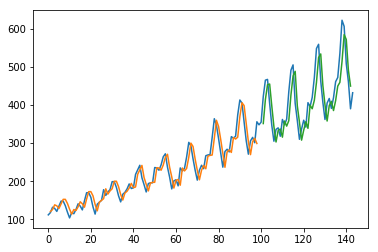

In [178]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()